In [418]:
import pandas as pd
import regex as re
import string
from matplotlib import pyplot as plt
import os

In [419]:
df = pd.read_pickle("./Data/MovieSummaries/plots_genres.pkl")
# Remove rows with empty genre
df = df[~df['genre'].apply(lambda x: len(x) == 0)]
#remove rows with nan genre
df = df[~df['genre'].isna()]

print(len(df))

41793


In [420]:
import pandas as pd

def process_less_than_threshold(df, count_threshold=50):
    df_exploded = df.explode('genre')

    # Count the occurrences of each string
    result = df_exploded['genre'].value_counts().reset_index()

    # Rename the columns for better clarity
    result.columns = ['String', 'Count']

    # Filter strings with count less than the threshold
    less_than_threshold = result[result['Count'] < count_threshold]
    less_than_threshold_list = less_than_threshold['String'].tolist()

    print(less_than_threshold_list)

    # Filter the original dataframe to remove rows containing less frequent genres
    df[df['genre'].apply(lambda x: any(target in x for target in less_than_threshold_list))]

    # Remove less frequent genres from the 'genre' column
    df['genre'] = df['genre'].apply(lambda x: [item for item in x if item not in less_than_threshold_list])

    # Remove rows with empty genre again
    df = df[~df['genre'].apply(lambda x: len(x) == 0)]

    return df

In [421]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove extra spaces
    text = re.sub(r' +', ' ', text)
    #remove leading and trailing spaces
    text = text.strip()
    return text

In [422]:
#write as function
def preprocess_genre(genre):
    genre = [preprocess_text(genre) for genre in genre]
    genre = [re.sub(r'\b(film|films|movie|movies|cinema|new|\'s)\b', '', genre) for genre in genre]
    genre = [genre.strip() for genre in genre]
    return genre

In [423]:
df['genre'] = df['genre'].apply(lambda x: preprocess_genre(x))

In [424]:
#reduce categories
unique_categories = list(set([category for sublist in df['genre'] for category in sublist]))

#remove empty strings
unique_categories = [category for category in unique_categories if category != '']

unique_categories


['prison',
 'romance',
 'roadshowcarny',
 'television',
 'alien invasion',
 'family',
 'martial arts',
 'teen',
 'workplace comedy',
 'heavenly comedy',
 'indie',
 'addiction drama',
 'marriage drama',
 'romantic thriller',
 'sci fi pictures original',
 'historical documentaries',
 'slice of life story',
 'medical fiction',
 'avantgarde',
 'natural disaster',
 'expressionism',
 'standup comedy',
 'political drama',
 'psychological thriller',
 'sports',
 'horse racing',
 'bwestern',
 'animation',
 'future noir',
 'caper story',
 'revisionist western',
 'linguistics',
 'rockumentary',
 'mystery',
 'sword and sandal',
 'grossout',
 'bloopers candid camera',
 'libraries and librarians',
 'science fiction western',
 'malayalam',
 'detective fiction',
 'precode',
 'cold war',
 'extreme sports',
 'beach party',
 'erotic drama',
 'werewolf fiction',
 'filmopera',
 'à clef',
 'swashbuckler',
 'dance',
 'science fiction',
 'women in prison',
 'epic western',
 'holiday',
 'revisionist fairy tale'

In [425]:
#clustering with TF-IDF (Term Frequency-Inverse Document Frequency) vectorization process in the provided code converts textual data (in this case, movie category names) into numerical vectors. 


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


# Extract category names
category_names = [category for category in unique_categories]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the category names using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(category_names)

# Perform K-means clustering with n clusters
kmeans = KMeans(n_clusters=15)
kmeans.fit(tfidf_matrix)

# Get the cluster labels for each category
cluster_labels = kmeans.labels_

# Create a dictionary to group categories by their cluster label
clusters = {}
for i, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(category_names[i])

# Print the movie categories grouped by "over genres"
for cluster_label, cluster_categories in clusters.items():
    print(f"Over Genre {cluster_label + 1}:")
    print(", ".join(cluster_categories))
    print()

c:\anaconda3\envs\nlp-project\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Over Genre 15:
prison, romance, roadshowcarny, alien invasion, family, martial arts, teen, indie, romantic thriller, sci fi pictures original, historical documentaries, avantgarde, natural disaster, expressionism, sports, horse racing, bwestern, future noir, linguistics, rockumentary, mystery, grossout, bloopers candid camera, malayalam, precode, extreme sports, beach party, filmopera, à clef, swashbuckler, dance, women in prison, holiday, revisionist fairy tale, samurai, monster, erotica, road, auto racing, british  wave, comdedy, biker, hip hop, spy, early black, roadshow theatrical release, punk rock, docudrama, zombie, about gladiators, northern, americana, childrens, education, action, alien, stoner, mockumentary, tragedy, interpersonal relationships, epic, pinku eiga, baseball, remake, essay, satire, filipino, parody, media studies, breakdance, stop motion, exploitation, whodunit, erotic thriller, ealing comedies, goat gland, disaster, gothic, tollywood, childrens fantasy, splatt

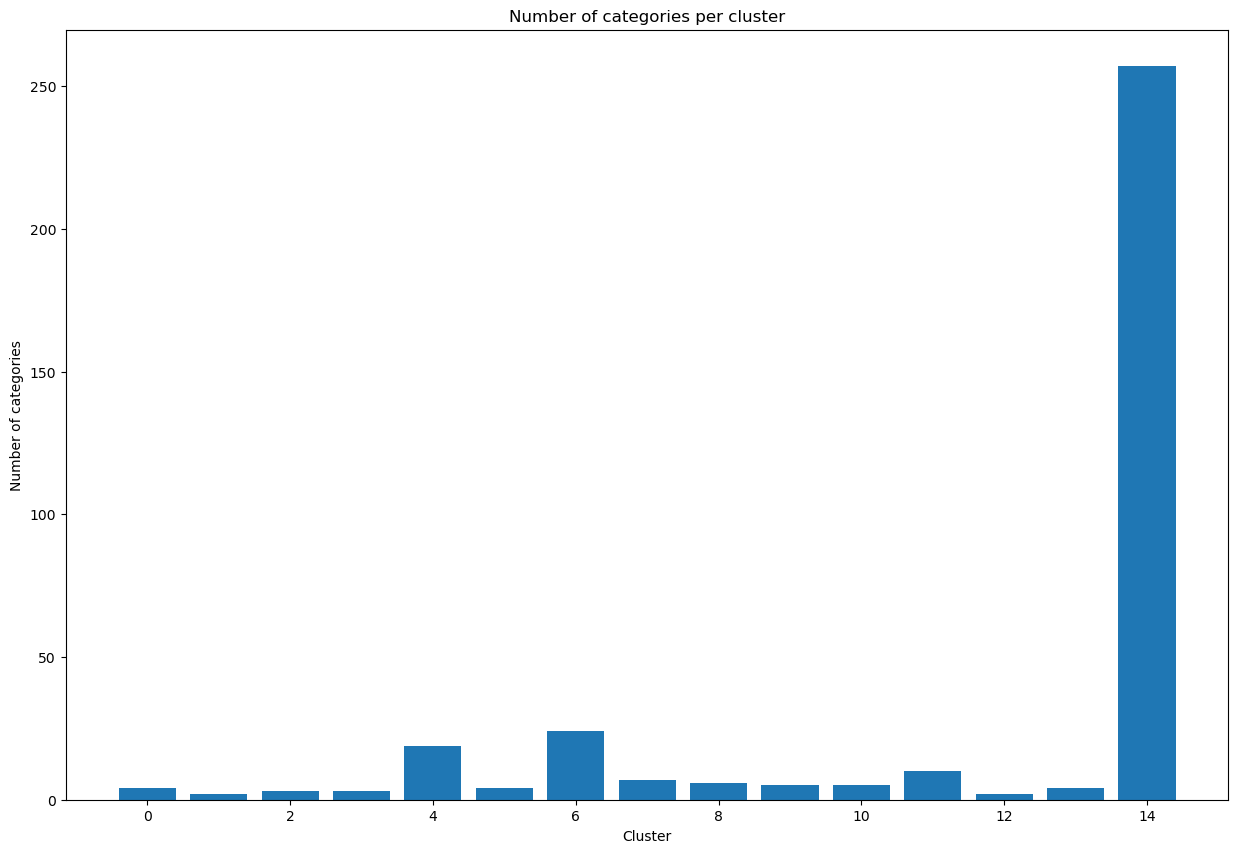

In [426]:
#show balance of clusters
plt.figure(figsize=(15,10))
plt.bar(clusters.keys(), [len(cluster) for cluster in clusters.values()])
plt.title('Number of categories per cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of categories')
plt.show()

In [427]:
# #Create a DataFrame from the 'clusters' dictionary
#if genre_clusters_tf-idf.csv already exists, skip this step
if not os.path.isfile('Data/MovieSummaries/genre_clusters_tf-idf.csv'):
    df_clusters = pd.DataFrame.from_dict(clusters, orient='index')

    #sort by index desc
    df_clusters = df_clusters.sort_index(ascending=True)
    #transpose
    df_clusters = df_clusters.transpose()

    # Write the DataFrame to a CSV file with a semicolon (;) separator
    df_clusters.to_csv('Data/MovieSummaries/genre_clusters_tf-idf.csv', index=False, sep=';')

#load the clusters from the csv file
df_clusters = pd.read_csv('Data/MovieSummaries/genre_clusters_tf-idf.csv', sep=';')

In [428]:
# #count occurences of each cluster in orignal df
# # iterate of each column of df_clusters, count for each element in the column how many times it appears in the original df and sum up the counts
# df_clusters_count = pd.DataFrame(df_clusters.apply(lambda x: df['genre'].apply(lambda y: x.isin(y).sum()).sum(), axis=0))
# df_clusters_count

In [429]:
# #plot the number of occurences of each cluster
# plt.figure(figsize=(15,10))
# plt.bar(df_clusters_count.index, df_clusters_count[0])
# plt.title('Number of occurences of each cluster')
# plt.xlabel('Cluster')
# plt.ylabel('Number of occurences')
# plt.show()

In [430]:
# rename clusters to more meaningful names
# cluster 0: suspense
# cluster 1: drama
# cluster 2: war
# cluster 3: western
# cluster 4: horror
# cluster 5: adventure
# cluster 6: family
# cluster 7: action
# cluster 8: crime
# cluster 9: gay
# cluster 10: political
# cluster 11: buddy
# cluster 12: miscallaneous
# cluster 13: comedy
# cluster 14: childrens

# rename columns of df_clusters

# Assuming you have a DataFrame named df_cluster
new_column_names = {
    '0': 'suspense',
    '1': 'drama',
    '2': 'war',
    '3': 'western',
    '4': 'horror',
    '5': 'adventure',
    '6': 'family',
    '7': 'action',
    '8': 'crime',
    '9': 'gay',
    '10': 'political',
    '11': 'buddy',
    '12': 'miscellaneous',
    '13': 'comedy',
    '14': 'childrens'
}

# Rename the columns
df_clusters.rename(columns=new_column_names, inplace=True)

df_clusters
#remove column "miscellaneous"
df_clusters.drop('miscellaneous', axis=1, inplace=True)

In [431]:
#replace in df the genre categories with the cluster names
# Create a dictionary to map the clusters to the genre categories
cluster_genre_map = {}
for cluster_label, cluster_categories in df_clusters.items():
    for category in cluster_categories:
        cluster_genre_map[category] = cluster_label

cluster_genre_map
#make to list
cluster_genre_map = list(cluster_genre_map.items())

#remove nan: 'childrens', from cluster_genre_map

cluster_genre_map

# Map the genre categories to the cluster names
#if not in cluster "miscellaneous", replace with genre
#if 'miscellaneous' not in cluster_genre_map:
# 
#df['genre'].apply(lambda x: [cluster_genre_map[category] for category in x])

#remove rows with empty genre
# df = df[~df['genre'].apply(lambda x: len(x) == 0)]

[('suspense', 'suspense'),
 (nan, 'childrens'),
 ('addiction drama', 'drama'),
 ('marriage drama', 'drama'),
 ('erotic drama', 'drama'),
 ('childhood drama', 'drama'),
 ('costume drama', 'drama'),
 ('legal drama', 'drama'),
 ('fantasy drama', 'drama'),
 ('drama', 'drama'),
 ('courtroom drama', 'drama'),
 ('historical drama', 'drama'),
 ('musical drama', 'drama'),
 ('romantic drama', 'drama'),
 ('inspirational drama', 'drama'),
 ('cold war', 'war'),
 ('women in prison', 'war'),
 ('the netherlands in world war ii', 'war'),
 ('war effort', 'war'),
 ('world', 'war'),
 ('parkour in popular culture', 'war'),
 ('gulf war', 'war'),
 ('world history', 'war'),
 ('war', 'war'),
 ('revisionist western', 'western'),
 ('science fiction western', 'western'),
 ('epic western', 'western'),
 ('indian western', 'western'),
 ('western', 'western'),
 ('spaghetti western', 'western'),
 ('comedy western', 'western'),
 ('space western', 'western'),
 ('acid western', 'western'),
 ('hybrid western', 'western'),

In [432]:
#run df_clusters for each column, except "miscellaneous" against df['genre'] and when a match is found, replace the genre with the cluster name
#df["genre"] = df["genre"].apply(lambda x: [cluster_genre_map[category] if category in cluster_genre_map else category for category in x])

In [438]:
# explode df['genre'] again and do the same as above
df_exploded = df.explode('genre')
df_exploded["genre"] = df_exploded["genre"].apply(lambda x: cluster_genre_map[x] if x in cluster_genre_map else x)

#count occurces of each genre
df_exploded['genre'].value_counts()
#show as txt
df_exploded['genre'].value_counts().to_csv('Data/MovieSummaries/genre_count.txt', sep=';')

In [434]:
# aggregate the rows again

df = df_exploded.groupby('id').agg({'text': 'first', 'title': 'first', 'genre': list}).reset_index()
print(len(df))
df = process_less_than_threshold(df, count_threshold=100)
print(len(df))
#count occurces of each genre
df_exploded = df.explode('genre')
df_exploded['genre'].value_counts()